In [1]:
import sys
# print(sys.executable)
import os
import json
from PIL import Image
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.ops as ops
import math
import random
from dotenv import load_dotenv

load_dotenv()



YT_ROOTS = ["D:\TLD-YT-part1", "D:\TLD-YT-part2"]

def extract_bbox_from_points(points):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    x1, x2 = min(xs), max(xs)
    y1, y2 = min(ys), max(ys)
    return [x1, y1, x2 - x1, y2 - y1]  # x, y, w, h
# brake_on, brake_off, left_signal, right_signal, hazard, off
def normalize_label(shape):
    raw = shape["label"]

    if "BrakeOn" in raw:
        return "brake_on"
    if "BrakeOff" in raw:
        return "brake_off"

    ts = shape.get("attributes", {}).get("turn_signal", "")
    if ts == "left":
        return "left_signal"
    if ts == "right":
        return "right_signal"
    if ts == "hazard":
        return "hazard"
    if ts == "off":
        return "off"
    print(ts)
    return "unknown"

def load_yt_dataset(root_dirs):
    samples = []

    for root in root_dirs:
        for dirpath, _, filenames in os.walk(root):
            jpg_files = [f for f in filenames if f.lower().endswith(".jpg")]

            for jpg in jpg_files:
                img_path = os.path.join(dirpath, jpg)
                json_path = os.path.join(dirpath, jpg.replace(".jpg", ".json"))

                if not os.path.exists(json_path):
                    # skip images without annotations
                    continue

                try:
                    with open(json_path, "r") as f:
                        ann = json.load(f)
                except:
                    # skip corrupted jsons
                    continue

                objects = []
                for shape in ann.get("shapes", []):
                    bbox = extract_bbox_from_points(shape["points"])
                    label = normalize_label(shape)
                    objects.append({"bbox": bbox, "label": label})

                samples.append({
                    "image_path": img_path,
                    "objects": objects
                })
                if (len(samples) % 1000 == 0):
                    print(f"Loaded {len(samples)} samples out of 111800")

    return samples

<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bencu\AppData\Local\Temp\ipykernel_15892\3758076851.py:14: SyntaxWarning: invalid escape sequence '\T'
  YT_ROOTS = ["D:\TLD-YT-part1", "D:\TLD-YT-part2"]
C:\Users\bencu\AppData\Local\Temp\ipykernel_15892\3758076851.py:14: SyntaxWarning: invalid escape sequence '\T'
  YT_ROOTS = ["D:\TLD-YT-part1", "D:\TLD-YT-part2"]


In [2]:
print('starting to load YT dataset...')
samples = load_yt_dataset(YT_ROOTS)
print("Total samples:", len(samples))


starting to load YT dataset...
Loaded 1000 samples out of 111800
Loaded 2000 samples out of 111800
Loaded 3000 samples out of 111800
Loaded 4000 samples out of 111800
Loaded 5000 samples out of 111800
Loaded 6000 samples out of 111800
Loaded 7000 samples out of 111800
Loaded 8000 samples out of 111800
Loaded 9000 samples out of 111800
Loaded 10000 samples out of 111800
Loaded 11000 samples out of 111800
Loaded 12000 samples out of 111800
Loaded 13000 samples out of 111800
Loaded 14000 samples out of 111800
Loaded 15000 samples out of 111800
Loaded 16000 samples out of 111800
Loaded 17000 samples out of 111800
Loaded 18000 samples out of 111800
Loaded 19000 samples out of 111800
Loaded 20000 samples out of 111800
Loaded 21000 samples out of 111800
Loaded 22000 samples out of 111800
Loaded 23000 samples out of 111800
Loaded 24000 samples out of 111800
Loaded 25000 samples out of 111800
Loaded 26000 samples out of 111800
Loaded 27000 samples out of 111800
Loaded 28000 samples out of 11180

In [3]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
model.to(device)
model.eval()
text_queries = [
    "vehicle",
    "car tail light",
    "brake light",
    "left turn signal",
    "right turn signal",
    "car hazard lights"
]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

In [ ]:
def visualize_prediction(img_path, ann_objects, draw=False):
    img = Image.open(img_path).convert("RGB")
    width, height = img.size

    inputs = processor(text=text_queries, images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.tensor([(height, width)])
    result = processor.post_process_grounded_object_detection(
        outputs=outputs,
        target_sizes=target_sizes,
        threshold=0.1,
        text_labels=[text_queries],
    )[0]

    boxes, scores, labels = result["boxes"], result["scores"], result["text_labels"]
    if draw:
        fig, ax = plt.subplots(1, figsize=(12, 7))
        ax.imshow(img)

        # truth
        for obj in ann_objects:
            x, y, w, h = obj["bbox"]
            ax.add_patch(patches.Rectangle(
                (x, y), w, h, linewidth=2, edgecolor="red", facecolor="none"
            ))
            ax.text(x, y - 5, obj["label"], color="red", fontsize=11, weight="bold")

        # Predictions
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box.tolist()
            w, h = x2 - x1, y2 - y1

            ax.add_patch(patches.Rectangle(
                (x1, y1), w, h, linewidth=1.2,
                edgecolor="lime", facecolor="none", zorder=10
            ))
            ax.text(
                x1, y1 - 5, f"{label} ({score:.2f})",
                color="lime", fontsize=11, weight="bold", zorder=11
            )

        plt.axis("off")
        plt.show()
    loss_value = taillight_loss(
        pred_boxes=torch.tensor(boxes),
        pred_labels=labels,
        pred_scores=scores,
        ann_objects=ann_objects
    )

    print("Loss:", loss_value)
    return loss_value


In [8]:

def taillight_loss(pred_boxes, pred_labels, pred_scores, ann_objects):
    """
    Computes a unified loss for taillight state detection.
    Lower = better.
    
    Components:
        - IoU loss: (1 - IoU)
        - Class loss: 0 if correct, weight if wrong
        - Confidence loss: (1 - score)
        - Brake mistakes weighted heavier
    """
    
    # Map model label → canonical GT label
    label_map = {
        "vehicle": "off",
        "car tail light": "off",
        "brake light": "brake_on",
        "left turn signal": "left_signal",
        "right turn signal": "right_signal",
        "car hazard lights": "hazard",
    }

    # Classification penalty weights (mistakes in brake_on cost more)
    class_penalty = {
        "brake_on": 4.0,       # biggest penalty
        "left_signal": 2.0,
        "right_signal": 2.0,
        "hazard": 2.5,
        "off": 1.0,
        "brake_off": 1.0,
    }
    if len(ann_objects) == 0:
        return 10.0 * len(pred_boxes) / math.log(len(pred_boxes) + 2)  # no objects = no loss

    if pred_boxes is None or len(pred_boxes) == 0:
        # Penalize missing all predictions
        return 10.0 * len(ann_objects) / math.log(len(ann_objects) + 1)

    # Convert GT boxes
    gt_boxes = []
    gt_labels = []
    for obj in ann_objects:
        x, y, w, h = obj["bbox"]
        gt_boxes.append([x, y, x + w, y + h])
        gt_labels.append(obj["label"])

    gt_boxes = torch.tensor(gt_boxes).float()

    # IoU matrix
    iou_mat = ops.box_iou(pred_boxes, gt_boxes)

    total_loss = 0.0

    # For each GT object, match the best prediction
    for gi, gt_label in enumerate(gt_labels):
        best_pi = torch.argmax(iou_mat[:, gi])
        best_iou = iou_mat[best_pi, gi].item()

        pred_label_raw = pred_labels[best_pi]
        pred_label = label_map.get(pred_label_raw, "off")
        pred_conf = pred_scores[best_pi].item()

        # --- Loss components ---
        iou_loss = 1 - best_iou                   # 0 when perfect overlap
        conf_loss = 1 - pred_conf                # 0 when high confidence

        if pred_label != gt_label:
            class_loss = class_penalty.get(gt_label, 1.0)
        else:
            class_loss = 0.0

        # Total loss per object
        obj_loss = iou_loss + conf_loss + class_loss
        total_loss += obj_loss
    return total_loss / math.log(len(ann_objects) + 1)  # average over GT objects


Showing sample 0: D:\TLD-YT-part1\C-3C1Dd129Q\C-3C1Dd129Q-part2\000001287.jpg


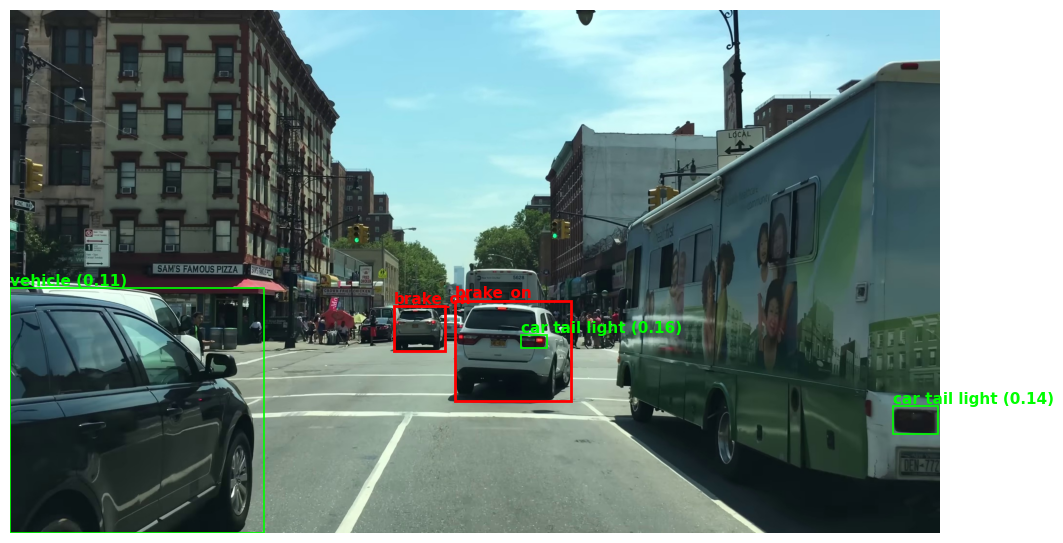

C:\Users\bencu\AppData\Local\Temp\ipykernel_15892\1313530416.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_boxes=torch.tensor(boxes),


Loss: 10.61038992844547
Showing sample 1: D:\TLD-YT-part1\C0h4SEjedlA\C0h4SEjedlA-part1\000000336.jpg


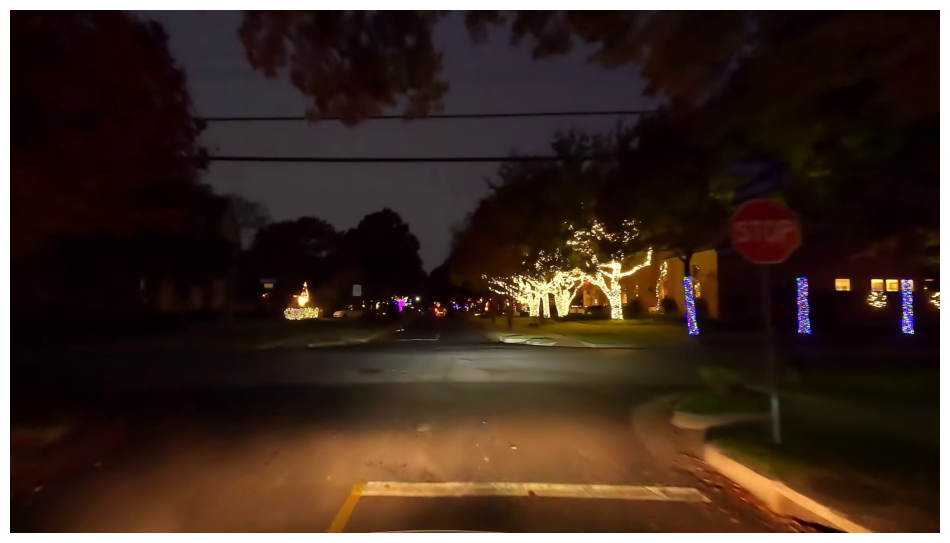

Loss: 0.0
Showing sample 2: D:\TLD-YT-part1\DcOj1FogG1U\DcOj1FogG1U-part3\000000975.jpg


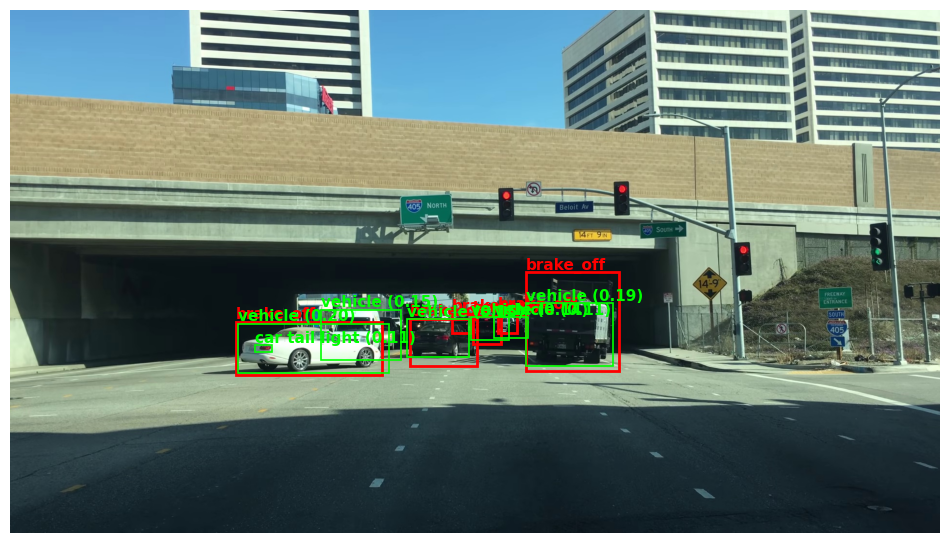

Loss: 10.17912550028806
Showing sample 3: D:\TLD-YT-part1\DmemHETDEVA\DmemHETDEVA-part8\000004737.jpg


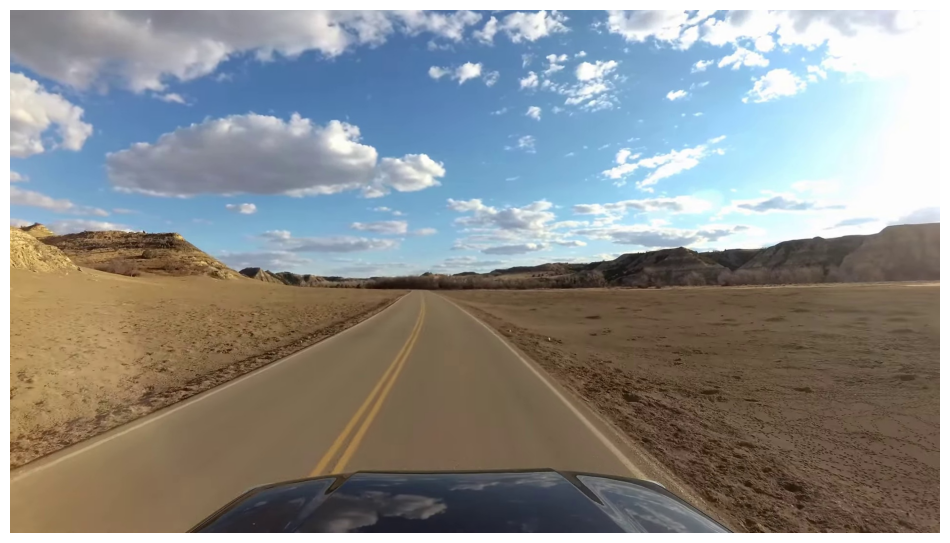

Loss: 0.0
Showing sample 4: D:\TLD-YT-part1\CTf2pj_ePXY\CTf2pj_ePXY-part3\000001477.jpg


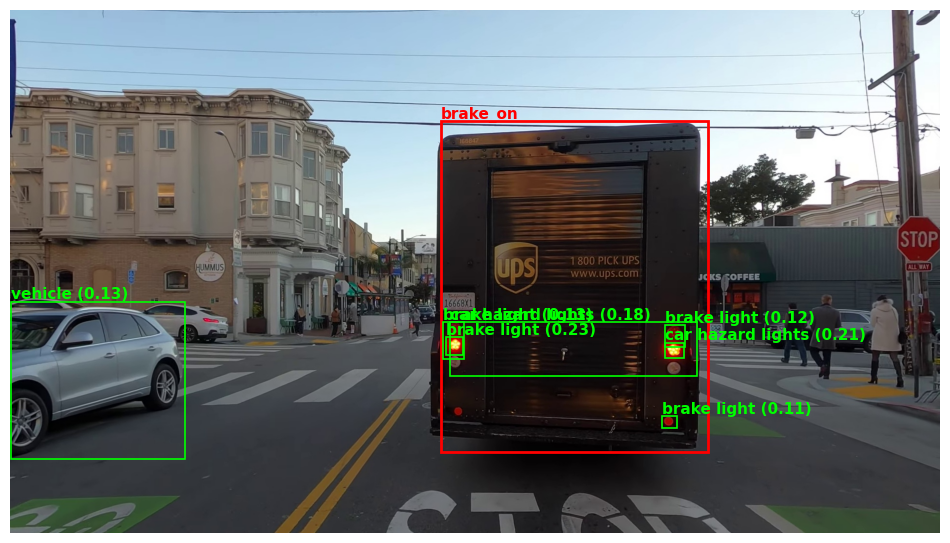

Loss: 8.184520294084715


In [9]:
for i in range(5):
    sample = samples[random.randint(0, len(samples) - 1)]
    print(f"Showing sample {i}: {sample['image_path']}")
    visualize_prediction(sample["image_path"], sample["objects"], draw=True)



Where does OWL-ViT fail in this safety-critical scenario?
